In [1]:
import numpy as np
import pandas as pd 
import astropy.units as u
from astropy.timeseries import LombScargle as lsp
import matplotlib.pyplot as plt
import nifty_ls   #not needed, but is what was used for periodogram. Install  with: "pip install nifty-ls".  more at: https://github.com/flatironinstitute/nifty-ls


# try:
#     plt.rc('text', usetex=True)
# except:
#     plt.rc('text', usetex=False)
# plt.rc('font', family='serif')

fig_width_pt = 244.0  # Get this from LaTeX using \the\columnwidth
text_width_pt = 508.0 # Get this from LaTeX using \the\textwidth

inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt*1.5 # width in inches
fig_width_full = text_width_pt*inches_per_pt*1.5  # 17
fig_height =fig_width*golden_mean # height in inches
fig_size = [fig_width,fig_height] #(9,5.5) #(9, 4.5)
fig_height_full = fig_width_full*golden_mean

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches


plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "figure.autolayout": True,
    "axes.grid": False,
    "text.usetex": False, #True
    "figure.figsize": fig_size
    # "xtick.minor.visible": True,
    # "ytick.minor.visible": True,
})

In [2]:
def detect_period_ap(times, fluxes, sector,fluxErr = None, plotting = False, knownFreq = None):
    """
    Calculates the periodogram with astropy and returns the period at the max power.
    """
    #* Seems to be sec 27 and 56 when it changes
    #12hr queries constant
    if sector <27: 
        nyquistP = 1*60*60*u.s #1/2hr ffi, so 1hr nyqist
    elif sector>=27 and sector<56:
        nyquistP = 20*60*u.s #1/6hr (10 min) ffi
    else: 
        nyquistP = 400*u.s   # 200 s ffi
    


    centredFlux = fluxes - np.mean(fluxes)

    minFreq = 1/(1468800*u.s) #* 1/17 days Mcneil 23

    maxFreq = 1/nyquistP 

    unitTimes = (u.Quantity(times, u.day)).to(u.s)

    lsper = lsp(unitTimes, centredFlux, dy=fluxErr)
    freqs, powers = lsper.autopower(minimum_frequency=minFreq, maximum_frequency=maxFreq, method="fastnifty")   #!remove 'method=' kwarg if NIFTY-LS is not used 
    bestPow = np.max(powers)
    bestFreq = freqs[np.argmax(powers)]

    t_fit=(np.linspace(times.min(),times.max(),1000)*u.day).to(u.s)
    y_fit = lsper.model(t_fit, bestFreq) + np.mean(fluxes)
    modelParams = lsper.model_parameters(bestFreq)
    f_a_prob = lsper.false_alarm_probability(np.max(powers),samples_per_peak=50, minimum_frequency=minFreq, maximum_frequency=maxFreq)

    if plotting:
        # fig, ax = plt.subplots(2, figsize = (12,8))

        fig, ax = plt.subplot_mosaic(
            """
            A
            A
            B
            B
            C
            """
            , figsize = (fig_width_full,fig_height_full)
        ) 


        comCol = "tab:orange"
        residCol = "tab:red"
        comMark = "D"
        residMark = "2"


        ax["A"].set_xscale("log")
        ax["A"].set_yscale("log")
        ax["A"].set(xlabel="Frequency (Hz)", ylabel="Power", ylim=(1e-3,bestPow+0.5))
        ax["A"].plot(freqs, powers, c="k", label="Periodogram")
        ax["A"].scatter(bestFreq,bestPow, c="gold",marker="*", s=100, label=f"Best Frequency = {bestFreq.value:.2e} Hz \nFalse Alarm Probability = {f_a_prob:.3e}")

        if knownFreq is not None:
            ax["A"].axvline(knownFreq, linestyle=":", c="tab:blue", label = f"Known F={knownFreq:.2e} Hz")
            ax["A"].axvline(2*knownFreq, linestyle=":", c="tab:purple", label = f"Known F alias (2*)")
            ax["A"].axvline(0.5*knownFreq, linestyle=":", c="tab:red", label = f"Known F alias (0.5*)")

        ax["A"].legend(fontsize=10)
        meanFlux = np.mean(fluxes)
        ax["B"].set(xlabel="Time (MJD)", ylabel="Flux (counts)")#, ylim=(meanFlux-100, meanFlux+100))
        # ax[1].scatter(times, fluxes, label = "Lightcurve", c="tab:orange", marker = "d", s=10)
        ax["B"].errorbar(times, fluxes,fluxErr, label="Centre of Mass Lightcuvre", markersize=1, markerfacecolor=comCol, fmt=comMark, ecolor=comCol,markeredgecolor=comCol)
        ax["B"].plot(t_fit.to(u.day),y_fit, ls="--", c="k", label="Model fit")
        ax["B"].legend()

        yofTimes = lsper.model(unitTimes, bestFreq) + np.mean(fluxes)

        resid = fluxes - yofTimes

        ax["C"].scatter(times, resid, s=2, c=residCol, marker=residMark)
        ax["C"].axhline(0, linestyle = ":", c="k")
        ax["C"].set(xlabel = "Time (MJD)", ylabel = "Residual")

    if plotting:
        return (1/bestFreq)/u.s, f_a_prob, modelParams, bestPow, fig, resid
    else:
        return (1/bestFreq)/u.s, f_a_prob, modelParams, bestPow


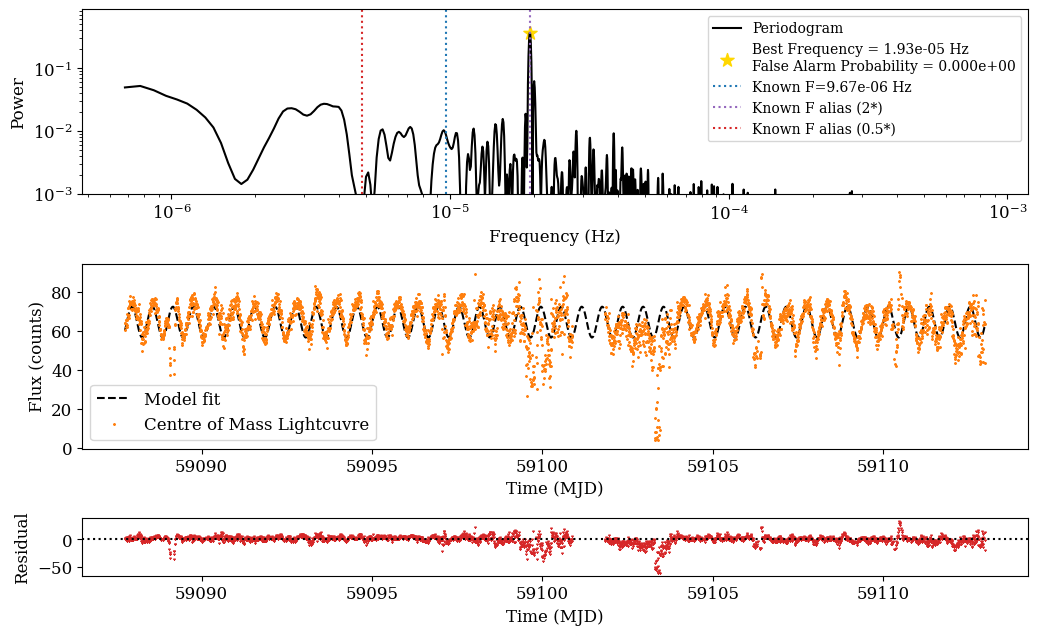

In [3]:
ulyssesLC = pd.read_csv("./Ulysses29LC.csv")

ulyssesLC.drop(columns="Unnamed: 0", inplace=True)

#from search of LCDB 
kPer=None
# kPer = 9.07417 #*Ceres
kPer = 28.72 #*Ulysses

if kPer is not None:
    kFreq = 1/(kPer*60*60)
else:
    kFreq=None


res = detect_period_ap(ulyssesLC["MJD"], ulyssesLC["COM Flux"], 29, plotting=True, knownFreq = kFreq)

res[4].savefig("./Ulysses29PeriodogramFig.pdf")